In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
# Get training property info

filename = 'Data/train_2016.csv'
trainid_df = pd.read_csv(filename)

# Get property info

colsToUse = ['parcelid', 'latitude', 'longitude', 'yearbuilt']
filename = 'Data/properties_2016.csv'
properties_df = pd.read_csv(filename, usecols = colsToUse)

In [3]:
# Put respective properties_df info into train_df.

properties_df.set_index('parcelid', inplace = True)
trainid_df.set_index('parcelid', inplace = True)

all_df = trainid_df.join(properties_df)

In [32]:
# Only use the necessary data.

all_df = all_df[['logerror', 'latitude', 'longitude', 'yearbuilt']]
all_df = all_df.dropna()
all_df['abslogerror'] = np.abs(all_df.logerror.values)

npoints = len(all_df.logerror.values)
origerror = np.mean(np.abs(all_df.logerror.values))

In [5]:
# Make function for binning values in an array

def makebins(X, nbins = 50):
    X2 = X.copy()
    maxval = np.amax(X2)
    minval = np.amin(X2)
    X2 = (X2 - minval) / (maxval - minval) * nbins
    X2 = X2.astype(int)
    X2 = minval + X2 * (maxval - minval) / nbins
    return X2

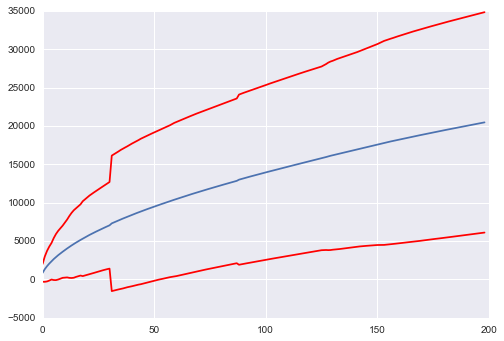

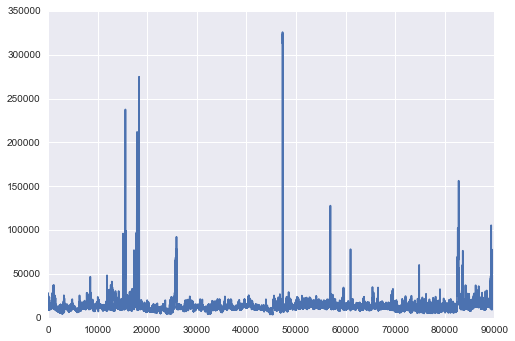

In [6]:
# Get statistics on neighbors for yearbuilt and distance

k = 200

coords = all_df[['latitude', 'longitude']].values
nbrs = NearestNeighbors()
nbrs.fit(coords)

nbrdistance, nbrindex = nbrs.kneighbors(coords, n_neighbors = k)
nbrdistance = nbrdistance[:,1:]
nbrindex = nbrindex[:,1:]
nbryear = all_df.yearbuilt.values[nbrindex]

meandistance = np.mean(nbrdistance, axis = 0)
stddistance = np.std(nbrdistance, axis = 0)
plt.plot(meandistance)
plt.plot(meandistance + stddistance, color = 'red')
plt.plot(meandistance - stddistance, color = 'red')
plt.show()

meandistance = np.mean(nbrdistance, axis = 1)
plt.plot(meandistance)
plt.show()

In [38]:
# Do PCA of neighbor distance.

meandist = np.mean(nbrdistance, axis = 0)
X = nbrdistance - meandist
distPCA = PCA()
distPCA.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

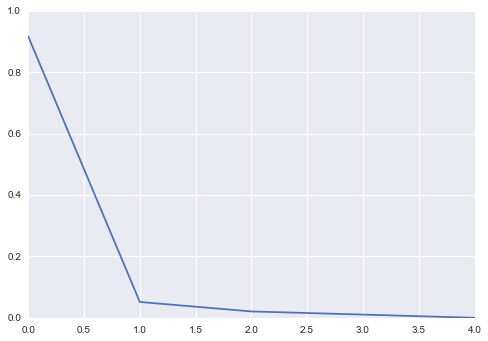

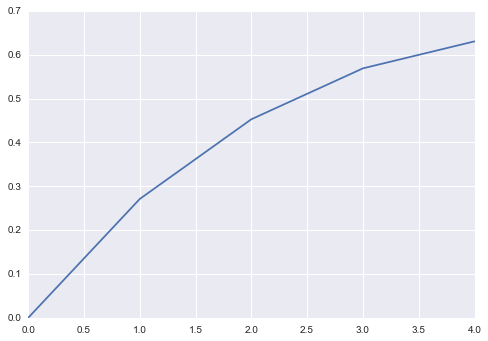

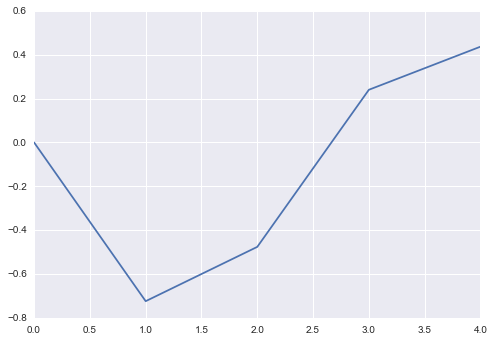

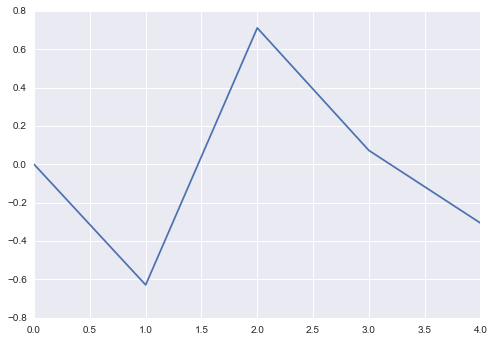

In [39]:
# Plot principle components of distance.

plt.plot(distPCA.explained_variance_ratio_[:5])
plt.show()

for i in range(3):
    plt.plot(distPCA.components_[i])
    plt.show()

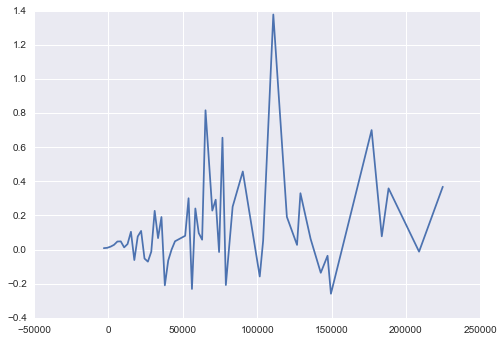

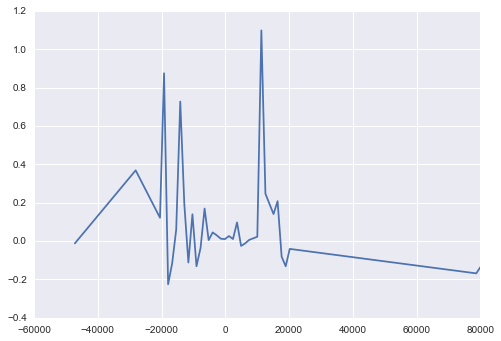

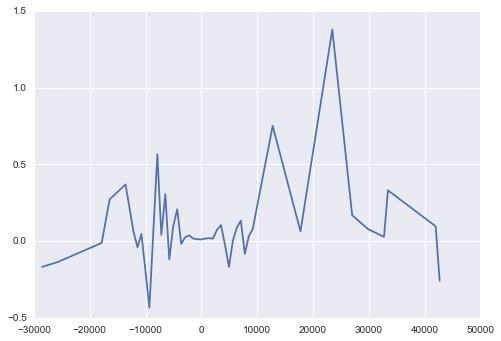

In [41]:
# Look at scatter plots.
X = nbrdistance - meandist
U = distPCA.fit_transform(X)[:,:3]

for i in range(3):
    bins = makebins(U[:,i], nbins = 100)
    all_df['bins'] = bins
    grouped_df = all_df.groupby('bins').mean()
    plt.plot(grouped_df.index.values, grouped_df.logerror.values)
    plt.show()

In [10]:
# Do PCA of neighbor year.

meanyear = np.mean(nbryear, axis = 0)
X = nbryear - meanyear
print(X.shape)
yearPCA = PCA()
yearPCA.fit(X)

(89519, 199)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

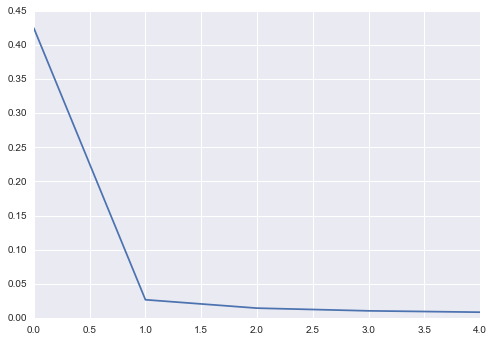

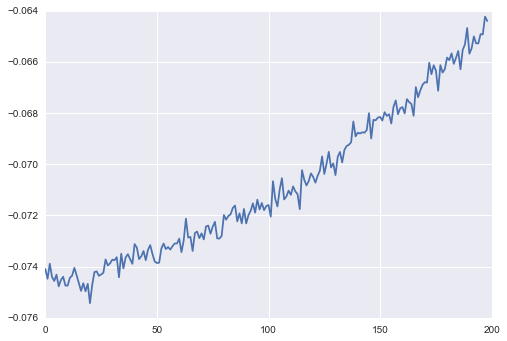

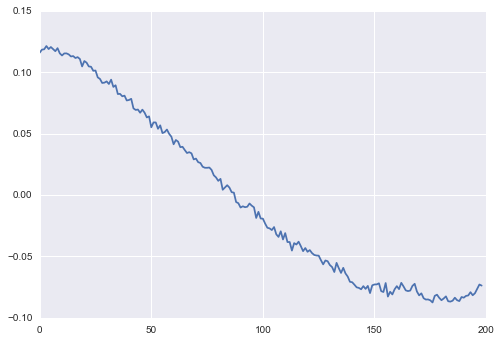

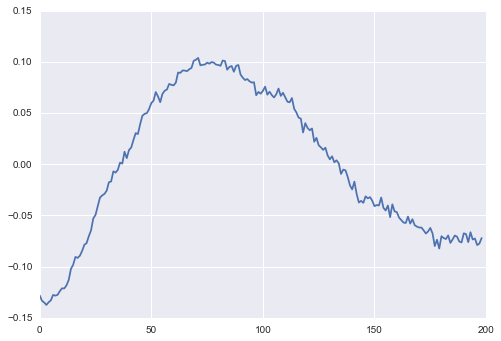

In [11]:
# Plot principle components of distance.

plt.plot(yearPCA.explained_variance_ratio_[:5])
plt.show()

for i in range(3):
    plt.plot(yearPCA.components_[i])
    plt.show()

(2387,)


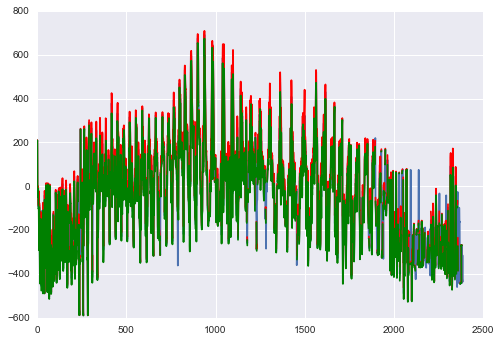

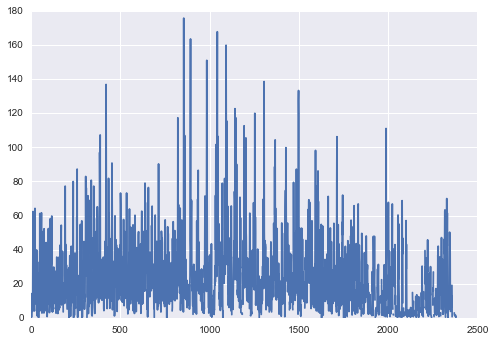

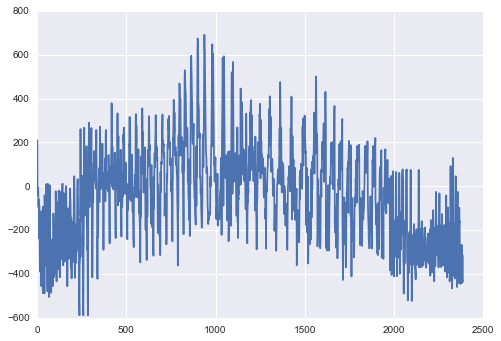

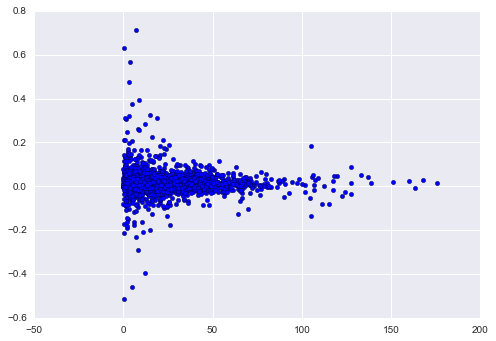

5.583532996460721

In [12]:
# Let's look at how much latitude and longitude is a proxy for this data.

X = nbryear - meanyear
y = yearPCA.fit_transform(X)[:,0]
X = all_df[['latitude', 'longitude']].values

bins1 = makebins(X[:,0], nbins = 100)
bins2 = makebins(X[:,1], nbins = 100)
all_df['bins1'] = bins1
all_df['bins2'] = bins2
all_df['y'] = y
grouped_df = all_df.groupby(['bins1', 'bins2']).mean()
meanproxy = grouped_df.y.values
meanlogerror = grouped_df.logerror.values

grouped_df = all_df.groupby(['bins1', 'bins2']).std()
stdproxy = grouped_df.y.values

print(meanproxy.shape)
plt.plot(meanproxy)
plt.plot(meanproxy + stdproxy, color = 'red')
plt.plot(meanproxy - stdproxy, color = 'green')
plt.show()
plt.plot(stdproxy)
plt.show()
plt.plot(meanproxy)
plt.show()

plt.scatter(stdproxy, meanlogerror)
plt.show()

stdproxy[6]

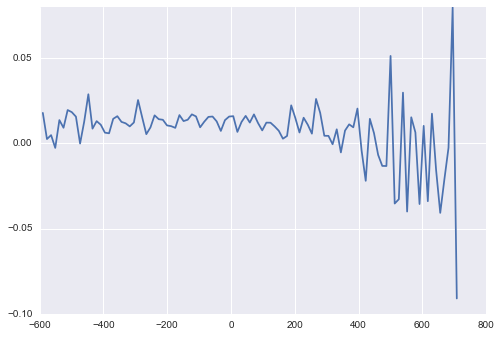

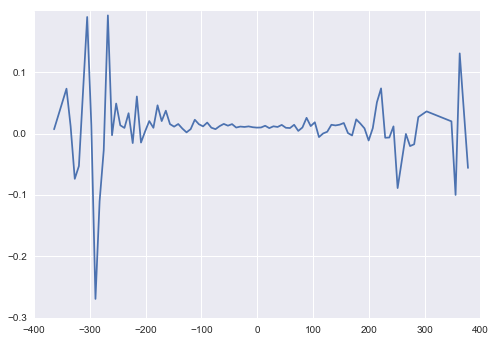

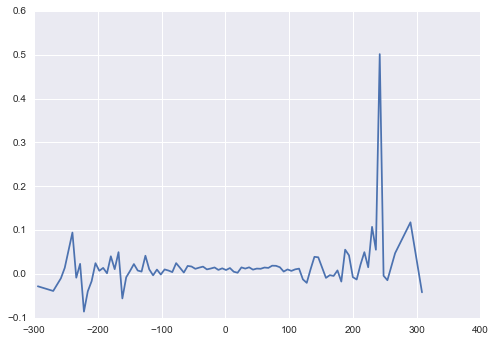

For training
0.067701594638
-0.00480228673909
For test
0.0670977379357
-0.00417951558237
For Total
0.0675808219484
-0.00467868345882


0.0060000000000000001

In [43]:
# Look at scatter plots.
X = nbryear - meanyear
U = yearPCA.fit_transform(X)[:,:3]

for i in range(3):
    bins = makebins(U[:,i], nbins = 100)
    all_df['bins'] = bins
    grouped_df = all_df.groupby('bins').mean()
    plt.plot(grouped_df.index.values, grouped_df.logerror.values)
    plt.show()
    
# Let's try a simple constant replacement

X = U[:, 0]
y = all_df.logerror.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)
p_train = np.zeros(y_train.shape)
p_test = np.zeros(y_test.shape)

indices = (-400 < X_train ) & (X_train < 200)
prediction = np.median(y_train[indices])
p_train[indices] = prediction
indices = (-400 < X_test ) & (X_test < 200)
p_test[indices] = prediction

print('For training')
e_train = np.abs(p_train - y_train)
e_train = np.mean(e_train)
print(e_train)
orig_train = np.mean(np.abs(y_train))
rel_train = (e_train - orig_train) / orig_train
print(rel_train)

print('For test')
e_test = np.abs(p_test - y_test)
e_test = np.mean(e_test)
print(e_test)
orig_test = np.mean(np.abs(y_test))
rel_test = (e_test - orig_test) / orig_test
print(rel_test)

print('For Total')
y_total = np.hstack((y_train, y_test))
p_total = np.hstack((p_train, p_test))
e_total = np.abs(p_total - y_total)
e_total = np.mean(e_total)
print(e_total)
origtotal = np.mean(np.abs(y_total))
rel_total = (e_total - origtotal) / origtotal
print(rel_total)


prediction

In [14]:
# Do PCA of neighbor year.
nbryeardiff = nbryear - all_df.yearbuilt.values.reshape(-1,1)
meandiff = np.mean(nbryeardiff, axis = 0)
X = nbryeardiff - meandiff
print(X.shape)
diffPCA = PCA()
diffPCA.fit(X)

(89519, 199)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

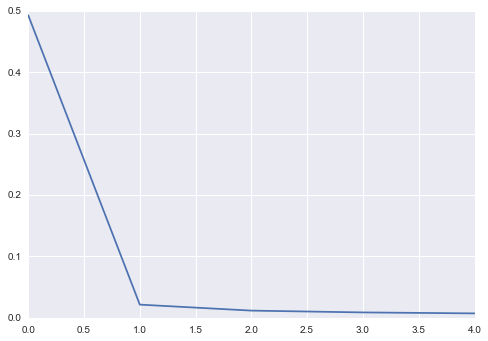

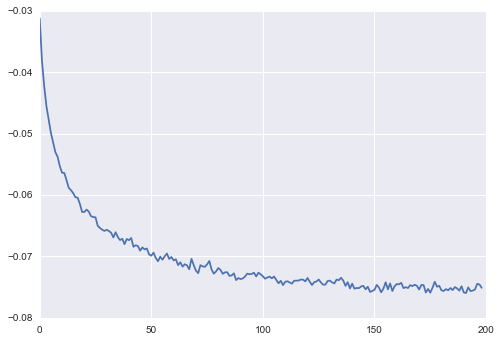

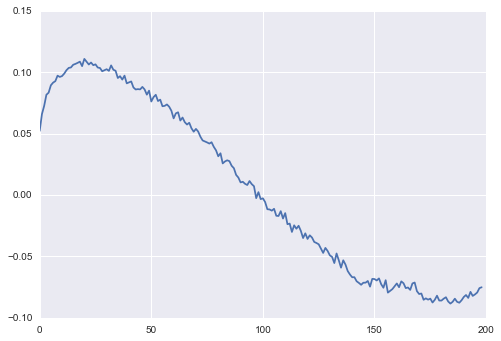

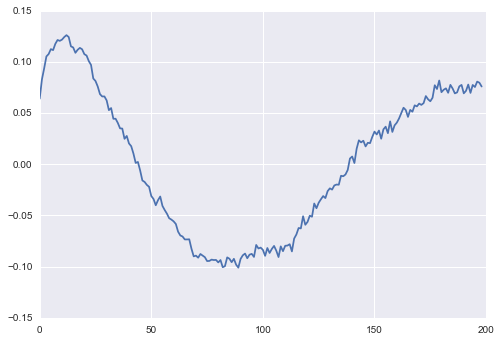

In [15]:
# Plot principle components of distance.

plt.plot(diffPCA.explained_variance_ratio_[:5])
plt.show()

for i in range(3):
    plt.plot(diffPCA.components_[i])
    plt.show()

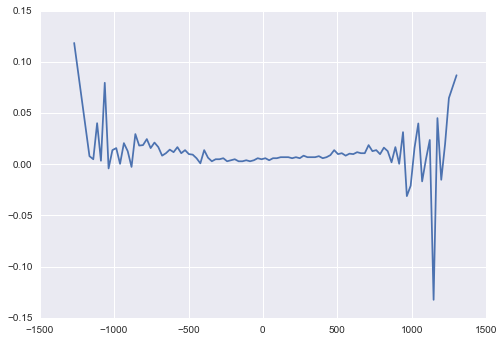

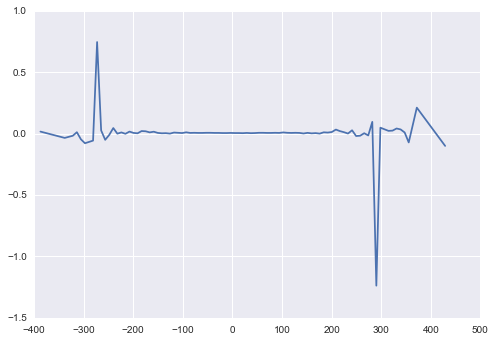

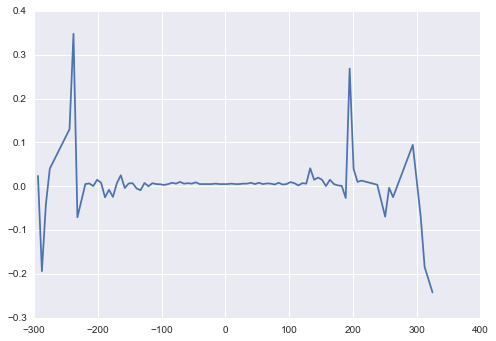

In [16]:
# Look at scatter plots.
X = nbryeardiff - meandiff
U = diffPCA.fit_transform(X)[:,:3]

for i in range(3):
    bins = makebins(U[:,i], nbins = 100)
    all_df['bins'] = bins
    grouped_df = all_df.groupby('bins').median()
    plt.plot(grouped_df.index.values, grouped_df.logerror.values)
    plt.show()

(50, 2)


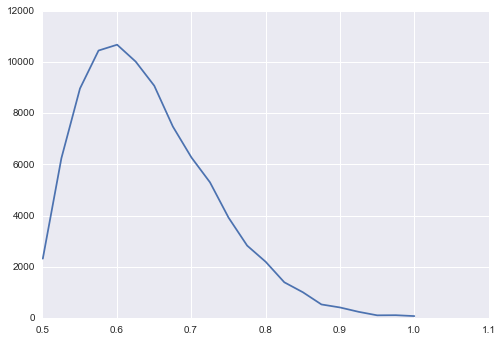

In [17]:
# Can we find streets by looking PCA of longitude and latitude for low neighbor numbers?

k = 50

coords = all_df[['latitude', 'longitude']].values
nbrs = NearestNeighbors()
nbrs.fit(coords)

nbrdistance, nbrindex = nbrs.kneighbors(coords, n_neighbors = k)

X = coords[nbrindex]
X.shape
streetPCA = PCA()
variations = np.zeros(len(X))
print(X[0].shape)
for i in range(len(X)):
    X2 = X[i]
    streetPCA.fit(X2)
    variations[i] = streetPCA.explained_variance_ratio_[0].copy()
    
X = makebins(variations, nbins = 20)
vals, counts = np.unique(X, return_counts = True)
plt.plot(vals, counts)
plt.show()

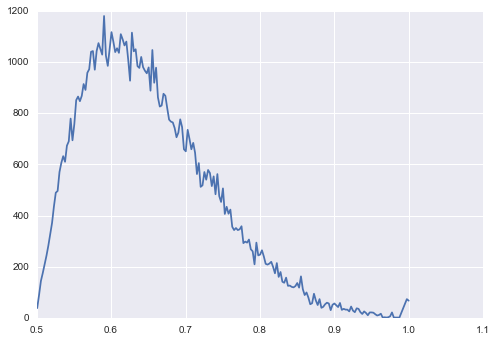

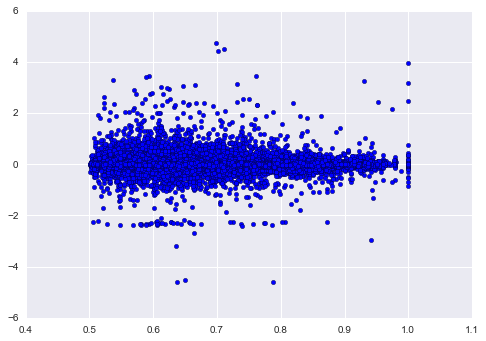

In [18]:
X = makebins(variations, nbins = 200)
vals, counts = np.unique(X, return_counts = True)
plt.plot(vals, counts)
plt.show()

plt.scatter(variations, all_df.logerror.values)
plt.show()

(89519, 10, 2)
(89519, 2)


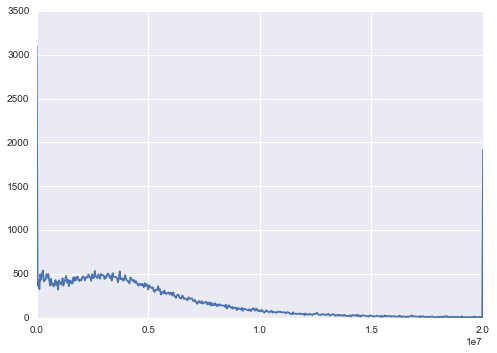

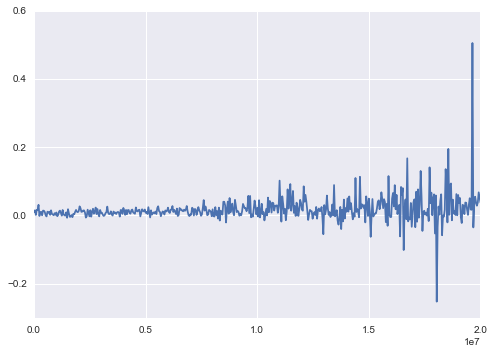

In [19]:
# Seems like some data have zero variance in some of their neighors. Apartments?

k = 10

coords = all_df[['latitude', 'longitude']].values
nbrs = NearestNeighbors()
nbrs.fit(coords)

nbrdistance, nbrindex = nbrs.kneighbors(coords, n_neighbors = k)

X = coords[nbrindex]
print(X.shape)
X = np.var(X, axis = 1)
print(X.shape)
X = np.sum(X, axis = 1)

cutoff = 0.2 * 10**8
X[X > cutoff] = cutoff

bins = makebins(X, nbins = 500)
all_df['bins'] = bins

grouped_df = all_df.groupby('bins').count()
plt.plot(grouped_df.index.values, grouped_df.logerror.values)
plt.show()

grouped_df = all_df.groupby('bins').mean()
plt.plot(grouped_df.index.values, grouped_df.logerror.values)
plt.show()

(89519, 2)
(89519, 5, 2)
(5, 2)


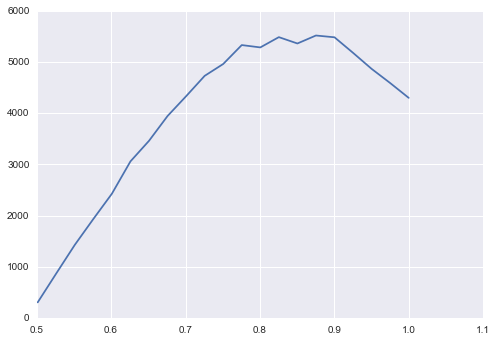

In [73]:
# Let's look for streets when total variation in neighbors is positive.

k = 5

coords = all_df[['latitude', 'longitude']].values
nbrs = NearestNeighbors()
nbrs.fit(coords)

nbrdistance, nbrindex = nbrs.kneighbors(coords, n_neighbors = k)

varcoords = coords[nbrindex]
varcoords = np.var(varcoords, axis = 1)
print(varcoords.shape)
varcoords = np.sum(varcoords, axis = 1)
indices = varcoords > 0

# Now look at PCA's
X = coords[nbrindex]
print(X.shape)
X = X[indices]

streetPCA = PCA()
variations = np.zeros(len(X))
print(X[0].shape)
U = np.zeros(len(X))
for i in range(len(X)):
    X2 = X[i]
    streetPCA.fit(X2)
    variations[i] = streetPCA.explained_variance_ratio_[0].copy()
    U[i] = np.arctan2(streetPCA.components_[0,0], streetPCA.components_[0,1])
    
X = makebins(variations, nbins = 20)
vals, counts = np.unique(X, return_counts = True)
plt.plot(vals, counts)
plt.show()

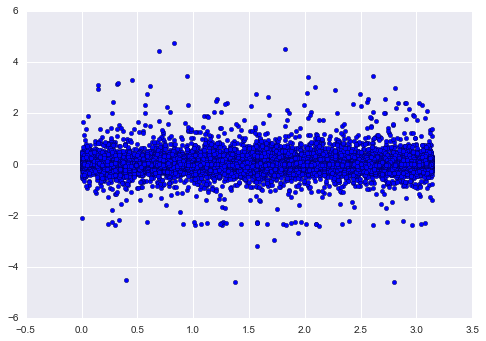

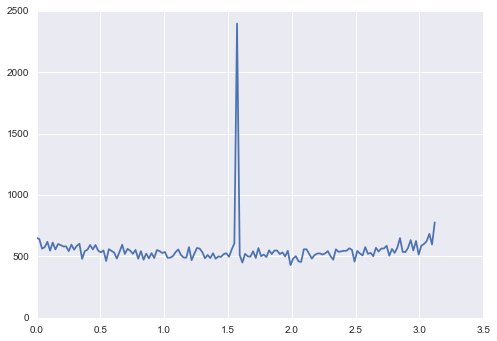

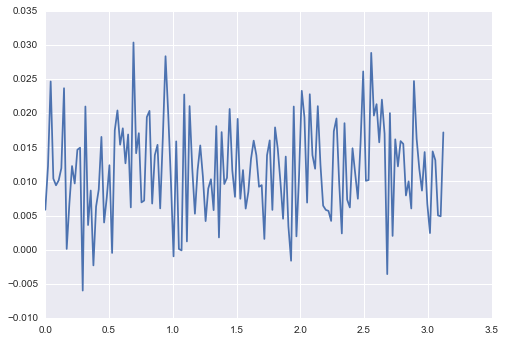

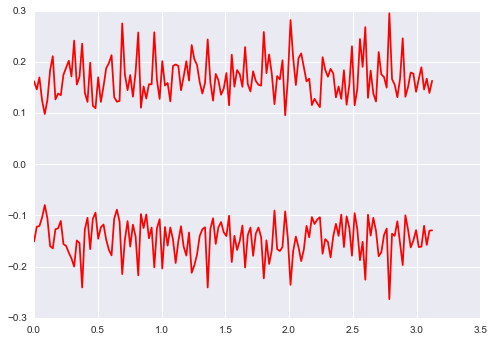

In [81]:
# Look at horizontalness of fundamental component, and if there is a relationship to logerror

y = all_df.logerror.values[indices]
plt.scatter(U, y)
plt.show()

nbins = 150
U = np.abs(U)
N, binedges = np.histogram(U, bins = nbins)
sumy, _ = np.histogram(U, bins = nbins, weights = y)
sumy2, _ = np.histogram(U, bins = nbins, weights = y**2)
meany = sumy / N
stdy = np.sqrt(sumy2 / N - meany**2)
plt.plot(binedges[:-1], N)
plt.show()
plt.plot(binedges[:-1], meany)
plt.show()
plt.plot(binedges[:-1], meany + stdy, color = 'red')
plt.plot(binedges[:-1], meany - stdy, color = 'red')
plt.show()

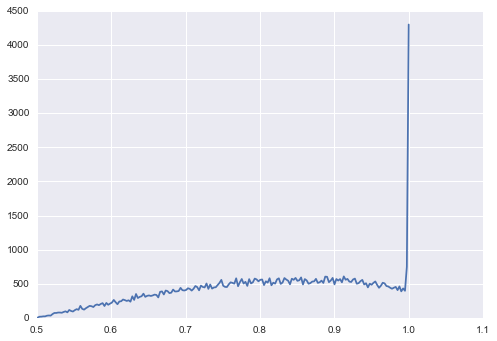

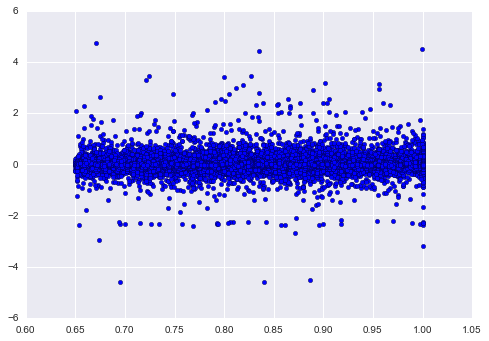

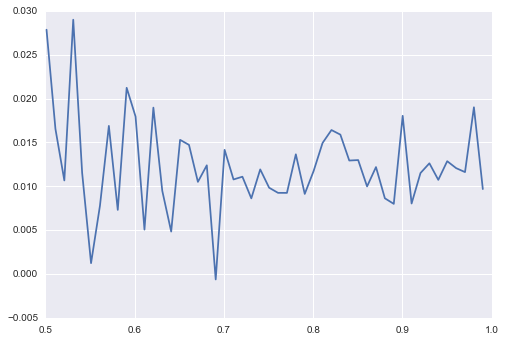

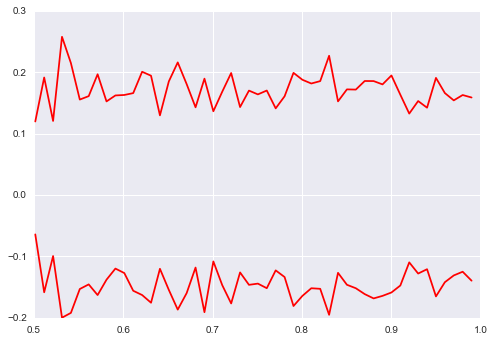

In [80]:
X = makebins(variations, nbins = 200)
vals, counts = np.unique(X, return_counts = True)
plt.plot(vals, counts)
plt.show()

y = all_df.logerror.values[indices]
cutoff = 0.65
X = variations[variations > cutoff]
y = y[variations > cutoff]
plt.scatter(X,y)
plt.show()

nbins = 50
y = all_df.logerror.values[indices]
N, binedges = np.histogram(variations, bins = nbins)
sumy, _ = np.histogram(variations, bins = nbins, weights = y)
sumy2, _ = np.histogram(variations, bins = nbins, weights = y**2)
meany = sumy / N
stdy = np.sqrt(sumy2 / N - meany**2)
plt.plot(binedges[:-1], meany)
plt.show()
plt.plot(binedges[:-1], meany + stdy, color = 'red')
plt.plot(binedges[:-1], meany - stdy, color = 'red')
plt.show()

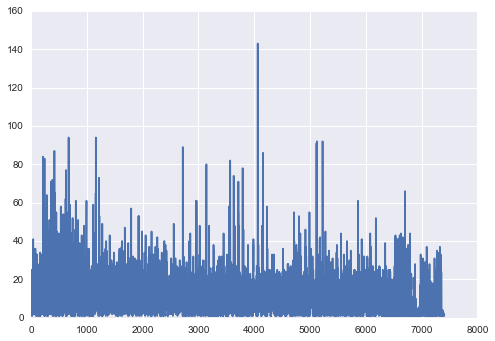

12.0987971347
10.3331633102


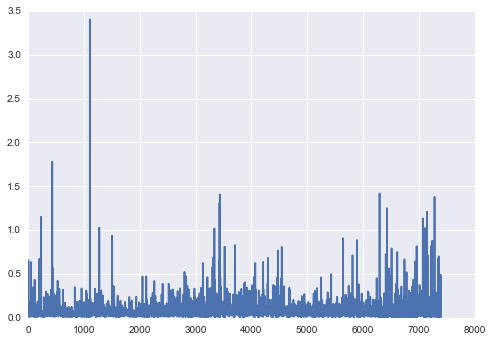

0.0771768540854
0.0973791638629


In [35]:
# Let's try to get an idea for how much latitude and longitude can be proxies for other quantities. To see this,
# let's get bin counts on latitude and longitude. Indicates how much we need to overfit for quantities that depend
# on a fine scale of position.

bins1 = makebins(all_df.latitude.values, nbins = 200)
bins2 = makebins(all_df.longitude.values, nbins = 200)
all_df['bins1'] = bins1
all_df['bins2'] = bins2
grouped_df = all_df.groupby(['bins1', 'bins2']).count()
plt.plot(grouped_df.logerror.values)
plt.show()

print(np.mean(grouped_df.logerror.values))
print(np.std(grouped_df.logerror.values))

grouped_df = all_df.groupby(['bins1', 'bins2']).mean()
plt.plot(grouped_df.abslogerror.values)
plt.show()

print(np.mean(grouped_df.abslogerror.values))
print(np.std(grouped_df.abslogerror.values))